In [1]:
from mocpy import MOC
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline

In [2]:
# Plot the polygon vertices on a matplotlib axis
def plot_graph(vertices):
    import matplotlib.pyplot as plt
    from matplotlib import path, patches
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    p = path.Path(vertices)
    patch = patches.PathPatch(p, facecolor='orange', lw=2)
    ax.add_patch(patch)

In [3]:
# Methods for defining random polygons
def generate_rand_polygon(num_points):
    lon_min, lon_max = (-5, 5)
    lat_min, lat_max = (-5, 5)
    lon = (np.random.random(num_points) * (lon_max - lon_min) + lon_min) * u.deg
    lat = (np.random.random(num_points) * (lat_max - lat_min) + lat_min) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

def generate_concave_polygon(num_points, lon_offset, lat_offset):
    delta_ang = (2 * np.pi) / num_points
    radius_max = 10
    
    angles = np.linspace(0, 2 * np.pi, num_points)
    radius = np.random.random(angles.shape[0]) * radius_max
    
    lon = (np.cos(angles) * radius + lon_offset) * u.deg
    lat = (np.sin(angles) * radius + lat_offset) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

def generate_convexe_polygon(num_points, lon_offset, lat_offset):
    delta_ang = (2 * np.pi) / num_points
    radius_max = 10
    
    angles = np.linspace(0, 2 * np.pi, num_points)
    radius = np.random.random() * radius_max * np.ones(angles.shape[0])
    
    lon = (np.cos(angles) * radius + lon_offset) * u.deg
    lat = (np.sin(angles) * radius + lat_offset) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

#vertices = generate_convexe_polygon(20, 10, 5)
vertices = generate_concave_polygon(20, 10, 5)

In [36]:
def plot(moc, moc_true, skycoord):
    from matplotlib import path, patches
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(10, 10))
    from mocpy import WCS

    from astropy.coordinates import Angle
    with WCS(fig, 
             fov=20 * u.deg,
             center=SkyCoord(200, 80, unit='deg', frame='icrs'),
             coordsys="icrs",
             rotation=Angle(0, u.degree),
             projection="TAN") as wcs:
        ax = fig.add_subplot(1, 1, 1, projection=wcs)

        moc.fill(ax=ax, wcs=wcs, edgecolor='r', facecolor='r', linewidth=1.0, fill=True, alpha=0.5)
        moc_true.fill(ax=ax, wcs=wcs, edgecolor='r', facecolor='b', linewidth=1.0, fill=True, alpha=0.5)

        from astropy.wcs.utils import skycoord_to_pixel
        x, y = skycoord_to_pixel(skycoord, wcs)
        p = path.Path(np.vstack((x, y)).T)
        patch = patches.PathPatch(p, facecolor='green', alpha=0.25, lw=2)
        ax.add_patch(patch)
    
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.grid(color='black', ls='dotted')
    plt.title('from polygon')
    plt.show()
    plt.close()

CPU times: user 137 ms, sys: 5.92 ms, total: 143 ms
Wall time: 139 ms


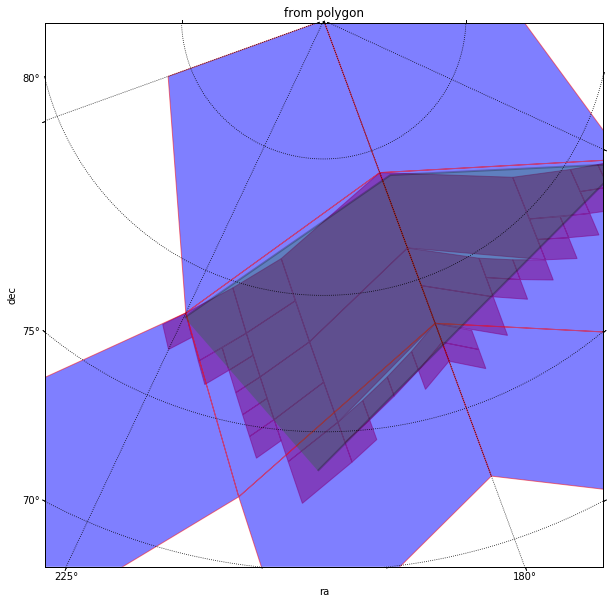

In [39]:
# Convert the vertices to lon and lat astropy quantities
lon, lat = vertices[:, 0] * u.deg, vertices[:, 1] * u.deg
moc_true = MOC.from_json({'3': [119, 125, 127, 187, 188, 190, 191]})

#lon = [65.11781779000003, 89.70533626000001, 60.23667431000001] * u.deg
#lat = [85.012424, 87.06130188, 85.609882] * u.deg

#lon = [359.70533626, 330.23667431, 335.11781779] * u.deg
#lat = [87.06130188, 85.60988200, 85.012424] * u.deg

lon = [224.86211710, 176.91129363, 135.81578643, 200.73574863] * u.deg
lat = [78.10924662, 83.92878811, 78.24840426, 73.58038790] * u.deg

skycoord = SkyCoord(lon, lat, unit="deg", frame="icrs")

# Define a vertex that is said to belongs to the MOC.
# It is important as there is no way on the sphere to know the area from
# which we want to build the MOC (a set of vertices delimits two finite areas).
inside = SkyCoord(ra=200, dec=80, unit="deg", frame="icrs")
%time moc = MOC.from_polygon(lon=lon, lat=lat, max_depth=6, inside=inside)
plot(moc, moc_true, skycoord)